We are downloading stock price data for 10 NASDAQ companies (e.g., AAPL, MSFT, etc.) for 2021. the companies that we are downloading stock prices: AAPL: Apple, Microsoft, Amazon, Alphabet (Google), Tesla , Meta (formerly Facebook),  NVIDIA, PayPal, Netflix, Comcast

In [ ]:
!pip install kneed

In [ ]:
# Import libraries
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

In [27]:
#  Top 10 companies in 2021
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA", "META", "NVDA", "PYPL", "NFLX", "CMCSA"]

all_data = pd.DataFrame()

for ticker in tickers:
    # Download stock data for the specific ticker in 2021
    stock_data = yf.download(ticker, start='2021-01-01', end='2021-12-31', progress=False)

    # Flatten multi-level column headers into a single level
    stock_data.columns = stock_data.columns.get_level_values(0)

    # Reset the index to make 'Date' a column
    stock_data = stock_data.reset_index()

    # Add the ticker symbol as a new column
    stock_data['Ticker'] = ticker

   # Append the current stock data to the main DataFrame
    all_data = pd.concat([all_data, stock_data])

# Save the data
all_data.to_csv("NASDAQ_Top10_2021.csv", index=False)


For line charts we visualize the stock trends for each company in 2021.

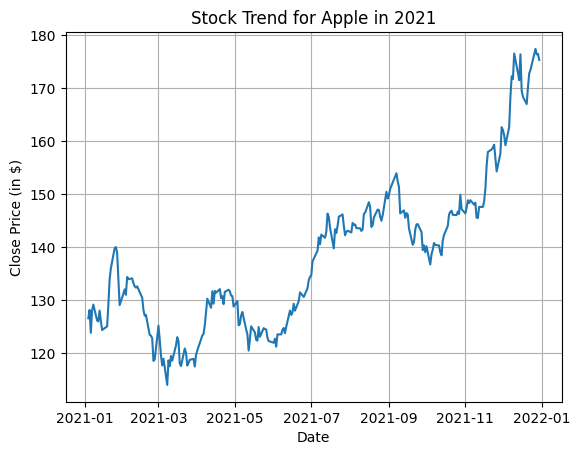

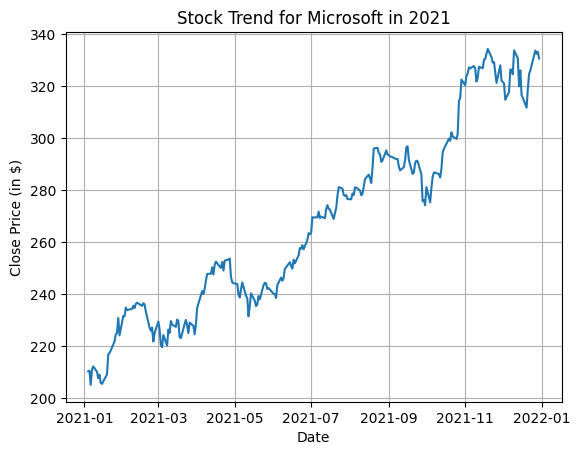

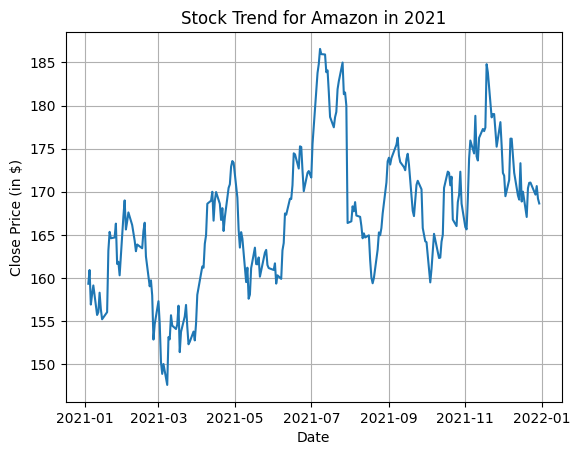

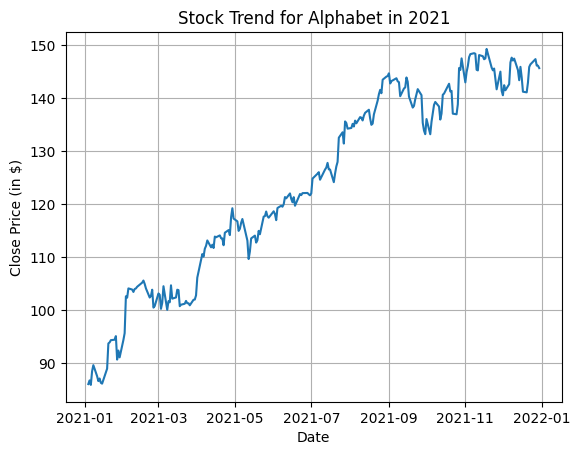

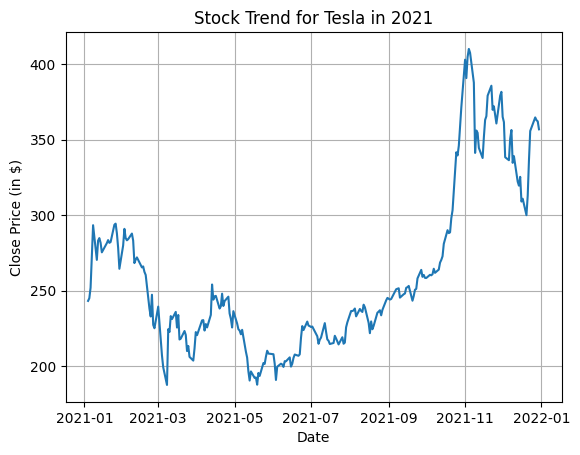

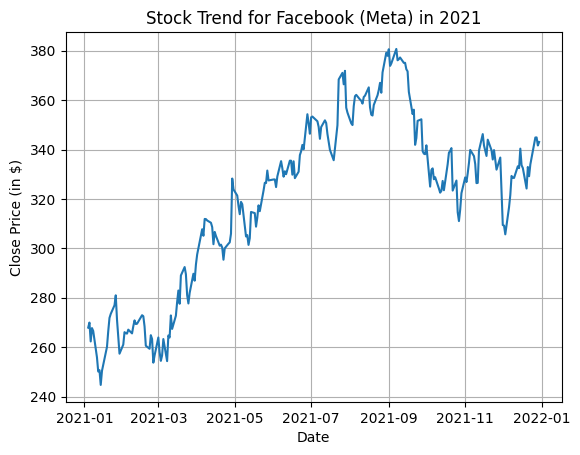

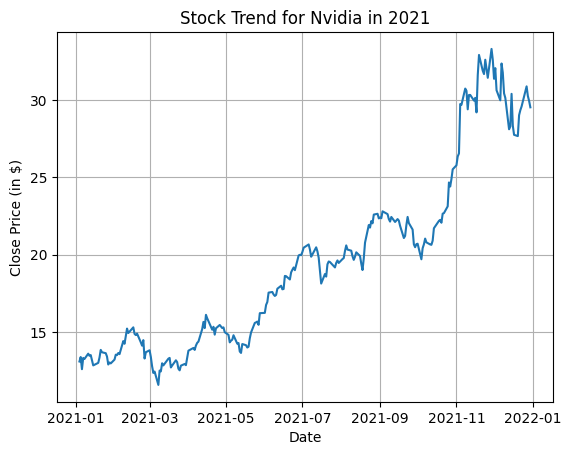

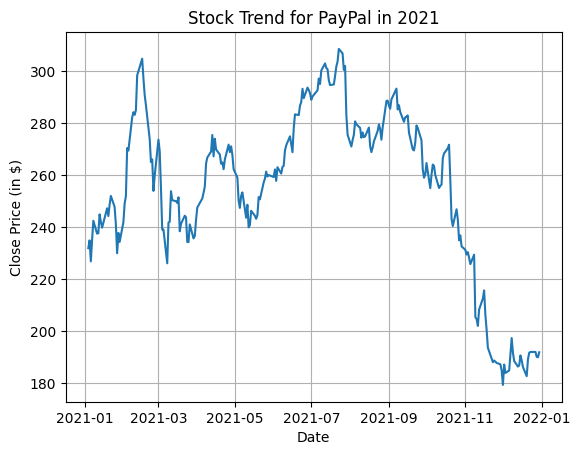

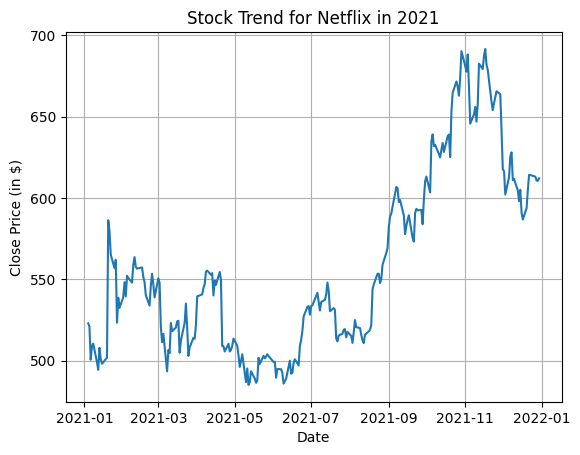

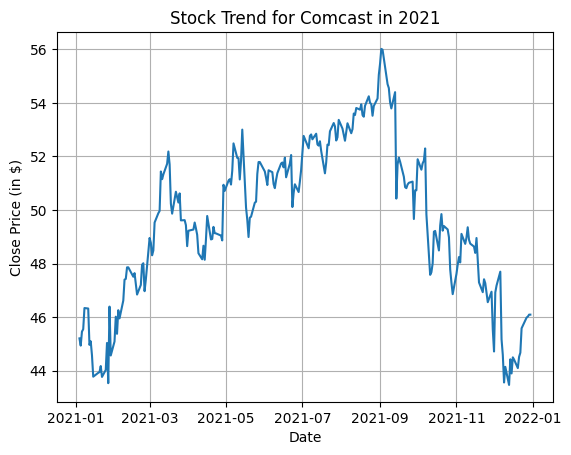

In [ ]:
# Connecting ticker to company names for better readability in the plots
ticker_to_name = {
    "AAPL": "Apple",
    "MSFT": "Microsoft",
    "AMZN": "Amazon",
    "GOOGL": "Alphabet",
    "TSLA": "Tesla",
    "META": "Facebook (Meta)",
    "NVDA": "Nvidia",
    "PYPL": "PayPal",
    "NFLX": "Netflix",
    "CMCSA": "Comcast"
}
# Loop over each company
for ticker in tickers:
    # Filter the data for the current company
    df = all_data[all_data['Ticker'] == ticker]
    # Create a new figure for each company
    plt.figure()
    # Plot the 'Close' price over time (index)
    plt.plot(df['Date'], df['Close'], label=f"{ticker} Closing Prices")
    # Set the title of the plot using the company's name (ticker_to_name[ticker])
    plt.title(f"Stock Trend for {ticker_to_name[ticker]} in 2021")
    # Label the x-axis and y-axis
    plt.xlabel("Date")
    plt.ylabel("Close Price (in $)")
    # Add a grid to make the plot easier to read
    plt.grid()
    # Save the plot as a PNG file with the company name
    plt.savefig(f"{ticker_to_name[ticker]}_line_chart.png")


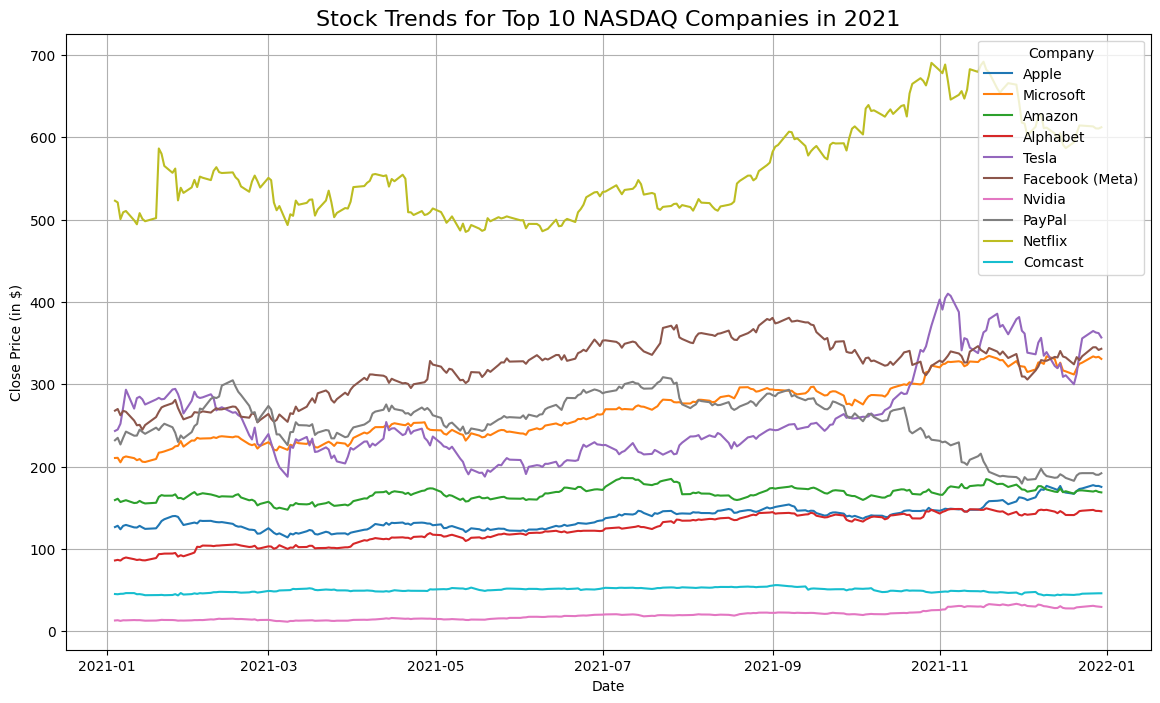

In [ ]:
# Set the bigger size so data is more readable
plt.figure(figsize=(14, 8))

# Loop through each company
for ticker in tickers:
    # Filter the data for the current company
    df = all_data[all_data['Ticker'] == ticker]

    # Plot the 'Close' price over time for each company
    plt.plot(df['Date'], df['Close'], label=ticker_to_name[ticker])

# Set the title, labels, legend and add grid
plt.title("Stock Trends for Top 10 NASDAQ Companies in 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Close Price (in $)")
plt.legend(title="Company")
plt.grid()

# Save the plot
plt.savefig("NASDAQ_Top10_Stock_Trends_2021.png")

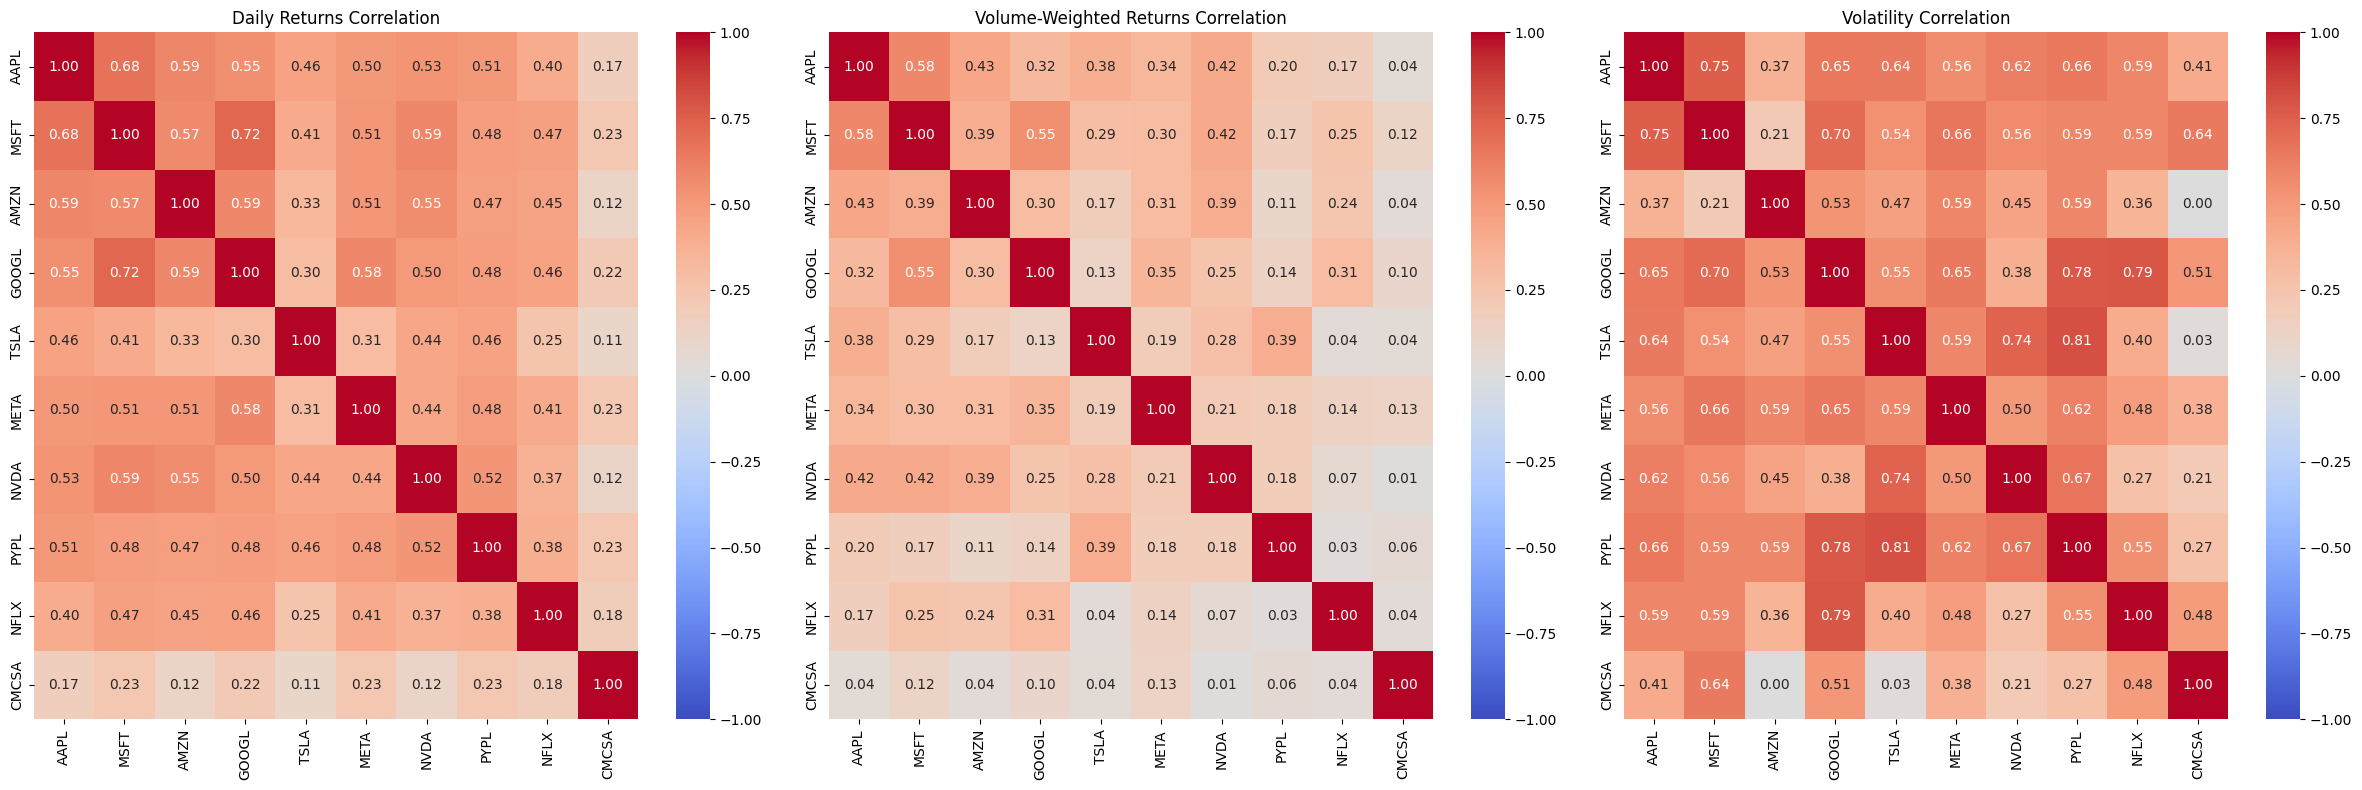


Most Correlated Pairs:

Top Returns Correlations:
MSFT - GOOGL: 0.720
AAPL - MSFT: 0.679
AAPL - AMZN: 0.590

Top Volume-Weighted Returns Correlations:
AAPL - MSFT: 0.580
MSFT - GOOGL: 0.548
AAPL - AMZN: 0.432

Top Volatility Correlations:
TSLA - PYPL: 0.812
GOOGL - NFLX: 0.788
GOOGL - PYPL: 0.778


In [ ]:
def calculate_advanced_metrics(data):
    """Calculate advanced correlation metrics for each stock"""
    # Create a new dataframe to store all metrics
    metrics_df = pd.DataFrame()

    for ticker in data['Ticker'].unique():
        stock_data = data[data['Ticker'] == ticker].copy()

        # 1. Daily Returns
        returns = stock_data['Close'].pct_change()

        # 2. Volume-Weighted Returns
        volume_weighted_returns = returns * (stock_data['Volume'] / stock_data['Volume'].mean())

        # 3. Standard Deviation of Returns (Traditional Volatility)
        rolling_std = returns.rolling(window=20).std() * np.sqrt(252)

        # Store metrics
        metrics_df[f'{ticker}_returns'] = returns
        metrics_df[f'{ticker}_vw_returns'] = volume_weighted_returns
        metrics_df[f'{ticker}_volatility'] = rolling_std

    return metrics_df

def create_correlation_matrices(metrics_df, tickers):
    # Separate metrics
    returns = metrics_df[[f'{ticker}_returns' for ticker in tickers]]
    vw_returns = metrics_df[[f'{ticker}_vw_returns' for ticker in tickers]]
    volatility = metrics_df[[f'{ticker}_volatility' for ticker in tickers]]

    # Clean up column names
    returns.columns = tickers
    vw_returns.columns = tickers
    volatility.columns = tickers

    # Create correlation matrices
    returns_corr = returns.corr()
    vw_returns_corr = vw_returns.corr()
    volatility_corr = volatility.corr()

    # Plot correlation matrices
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    # Daily Returns Correlation
    sns.heatmap(returns_corr,
                annot=True,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                fmt='.2f',
                ax=axes[0])
    axes[0].set_title('Daily Returns Correlation')

    # Volume-Weighted Returns Correlation
    sns.heatmap(vw_returns_corr,
                annot=True,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                fmt='.2f',
                ax=axes[1])
    axes[1].set_title('Volume-Weighted Returns Correlation')

    # Volatility Correlation
    sns.heatmap(volatility_corr,
                annot=True,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                fmt='.2f',
                ax=axes[2])
    axes[2].set_title('Volatility Correlation')

    plt.tight_layout()
    plt.savefig('Advanced_Correlations.png')
    plt.show()

    return returns_corr, vw_returns_corr, volatility_corr

def print_correlation_summary(returns_corr, vw_returns_corr, volatility_corr, tickers):
    print("\nMost Correlated Pairs:")

    # Function to get top correlations
    def get_top_correlations(corr_matrix, metric_name):
        correlations = []
        for i in range(len(tickers)):
            for j in range(i+1, len(tickers)):
                correlations.append({
                    'Stock1': tickers[i],
                    'Stock2': tickers[j],
                    'Correlation': corr_matrix.iloc[i,j]
                })

        # Sort by absolute correlation
        correlations.sort(key=lambda x: abs(x['Correlation']), reverse=True)
        print(f"\nTop {metric_name} Correlations:")
        for corr in correlations[:3]:
            print(f"{corr['Stock1']} - {corr['Stock2']}: {corr['Correlation']:.3f}")

    get_top_correlations(returns_corr, "Returns")
    get_top_correlations(vw_returns_corr, "Volume-Weighted Returns")
    get_top_correlations(volatility_corr, "Volatility")

# Calculate metrics and create visualizations
metrics_df = calculate_advanced_metrics(all_data)
returns_corr, vw_returns_corr, volatility_corr = create_correlation_matrices(metrics_df, tickers)
print_correlation_summary(returns_corr, vw_returns_corr, volatility_corr, tickers)

In [ ]:
# Convert 'Date' column to date time format
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Group data by month and get last trading day's values for each company
monthly_data = all_data.groupby([pd.Grouper(key='Date', freq='M'), 'Ticker']).last().reset_index()

# Save data
monthly_data.to_csv("monthly_last_values.csv", index=False)

<ipython-input-22-56ce59a814e1>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = all_data.groupby([pd.Grouper(key='Date', freq='M'), 'Ticker']).last().reset_index()


In [ ]:
def calculate_monthly_metrics(data):
    """Calculate monthly volatility metrics for each stock"""
    monthly_metrics = []

    for ticker in data['Ticker'].unique():
        stock_data = data[data['Ticker'] == ticker].copy()
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])
        stock_data['Month'] = stock_data['Date'].dt.to_period('M')
        stock_data['Returns'] = stock_data['Close'].pct_change()

        monthly_group = stock_data.groupby('Month').agg({
            'Returns': [
                ('std_vol', lambda x: x.std() * np.sqrt(252)),
                ('mean_return', 'mean')
            ],
            'High': 'max',
            'Low': 'min',
            'Close': ['first', 'last'],
            'Volume': 'mean'
        })

        monthly_group.columns = ['_'.join(col).strip() for col in monthly_group.columns.values]

        monthly_data = pd.DataFrame({
            'Ticker': ticker,
            'Month': monthly_group.index,
            'Std_Volatility': monthly_group['Returns_std_vol'],
            'Monthly_Return': ((monthly_group['Close_last'] - monthly_group['Close_first']) /
                             monthly_group['Close_first']) * 100,
            'Price_Range': ((monthly_group['High_max'] - monthly_group['Low_min']) /
                          monthly_group['Low_min']) * 100,
            'Avg_Volume': monthly_group['Volume_mean']
        })

        monthly_metrics.append(monthly_data)

    return pd.concat(monthly_metrics, ignore_index=True)

# Calculate monthly metrics
monthly_metrics = calculate_monthly_metrics(all_data)

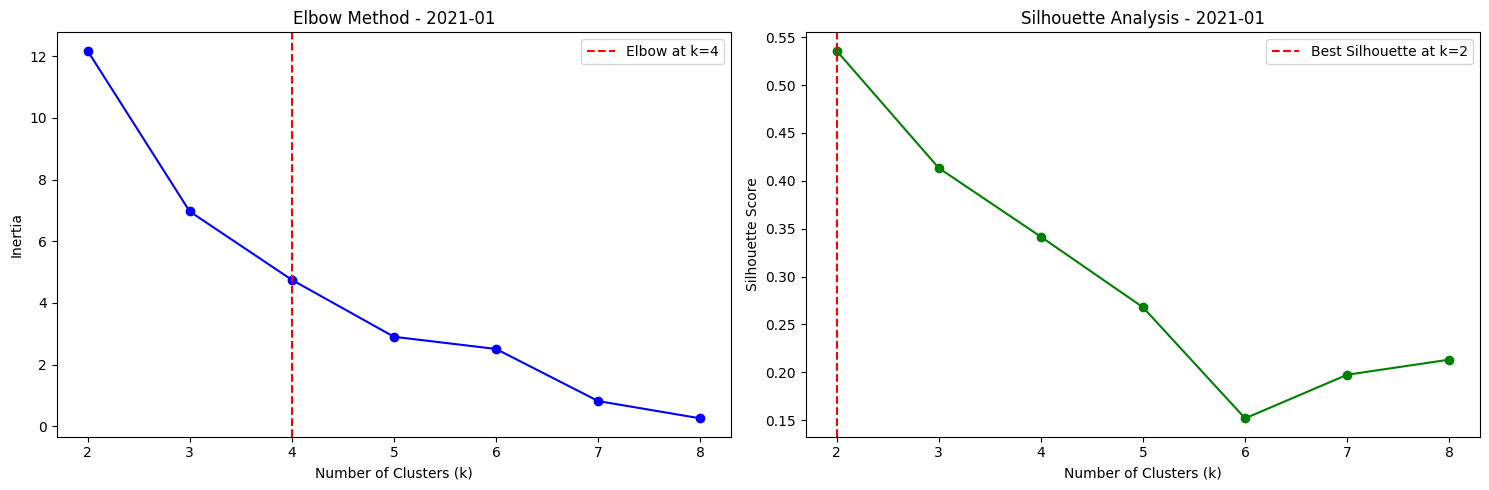

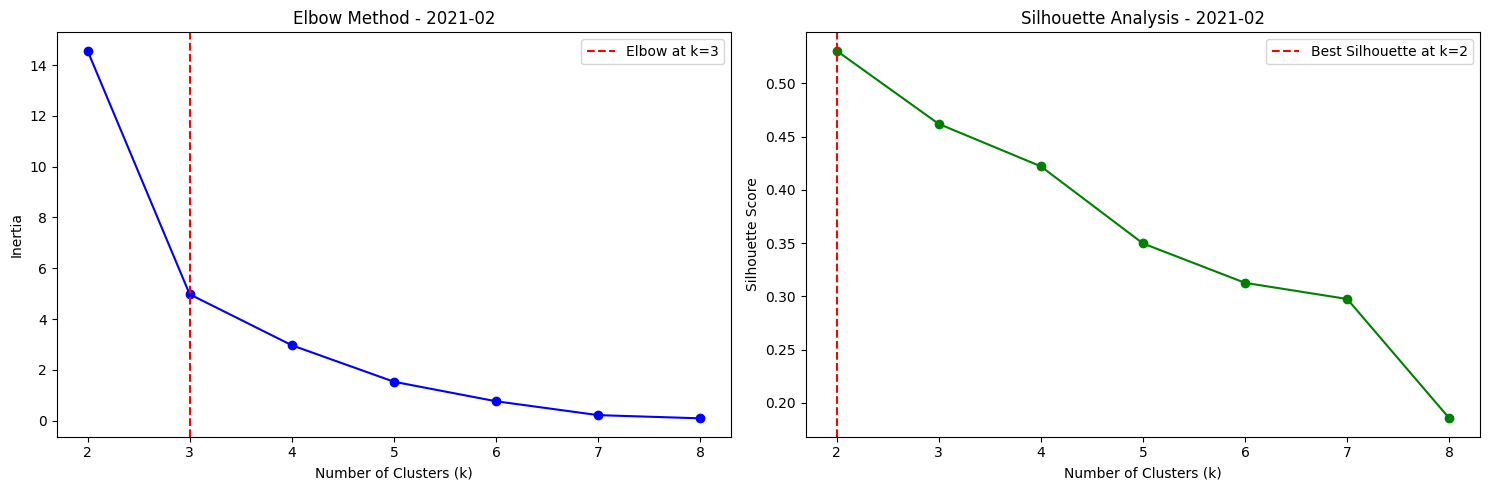

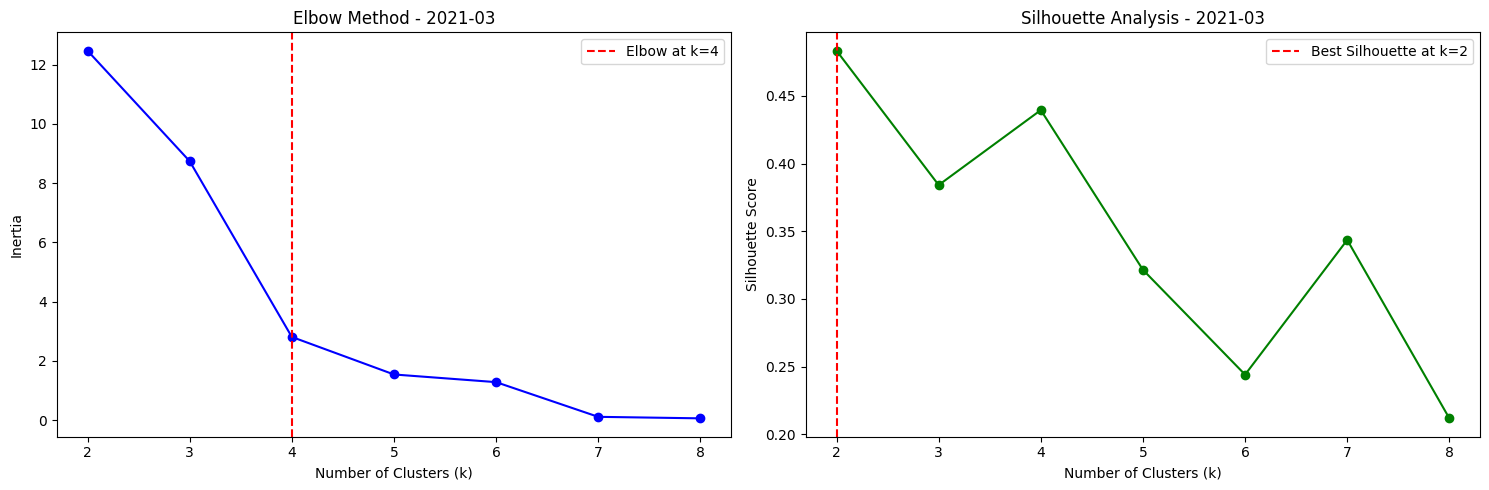

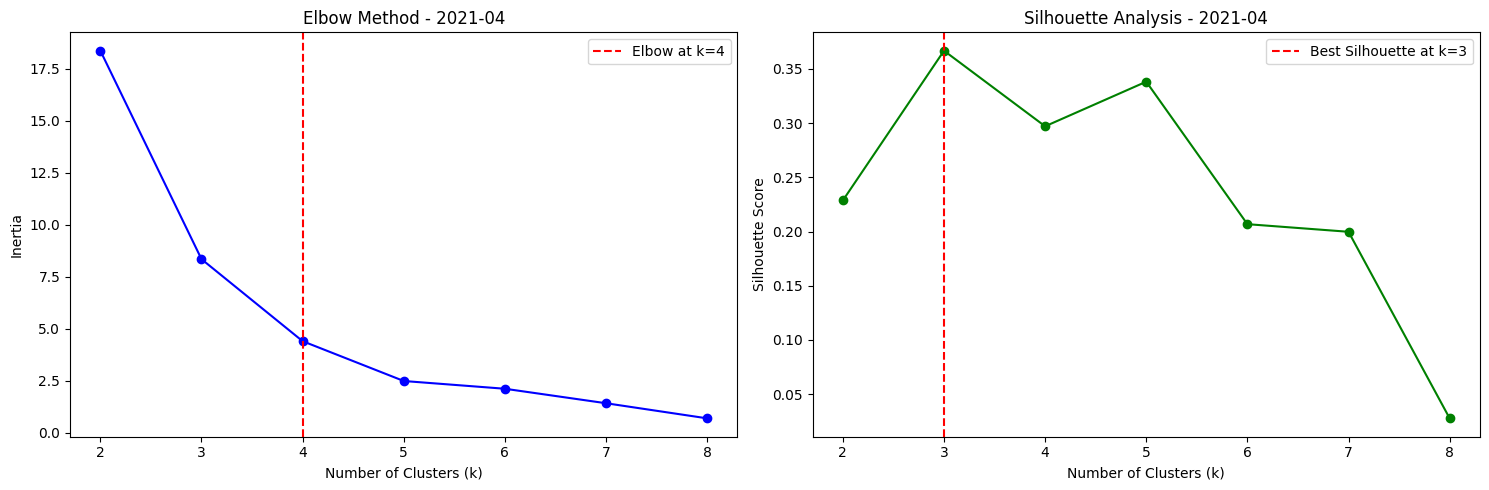

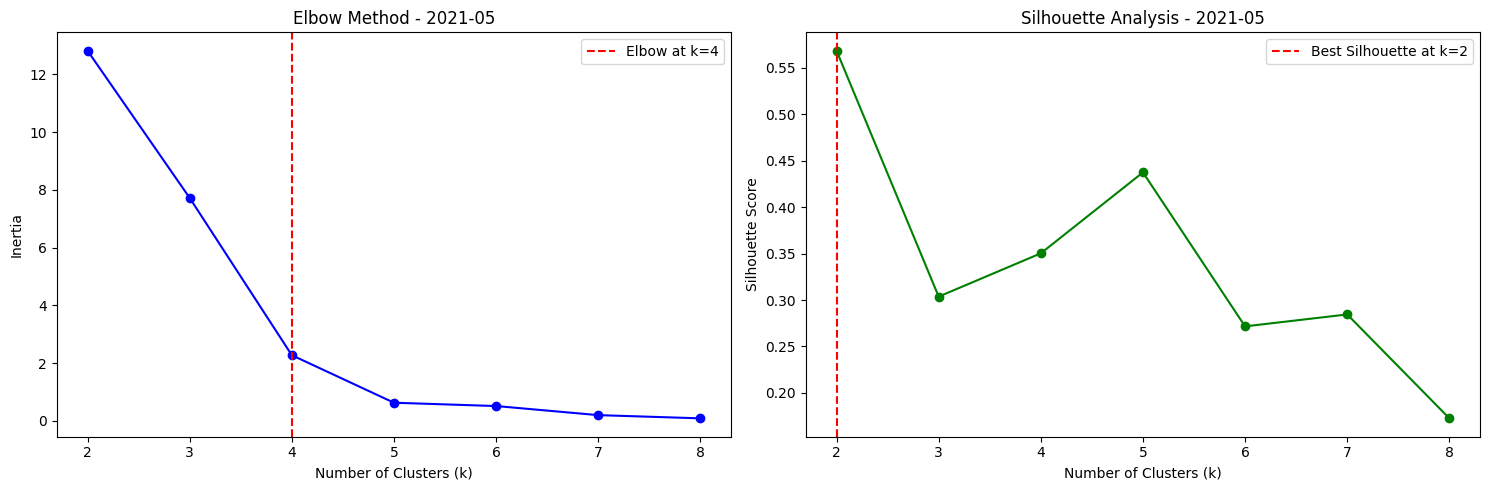

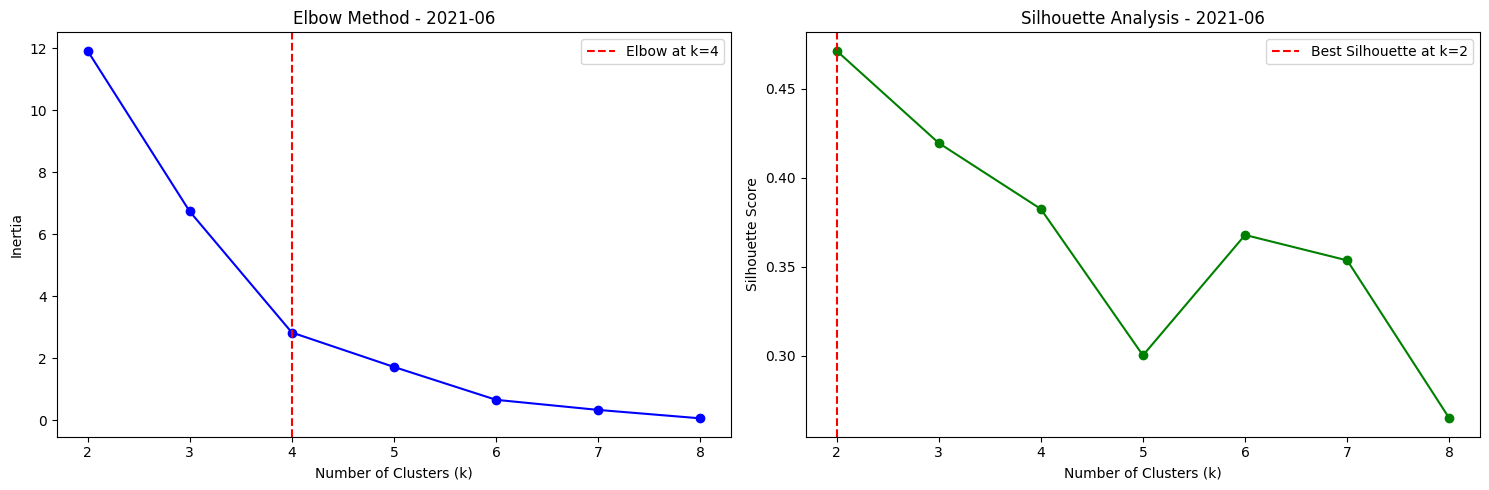

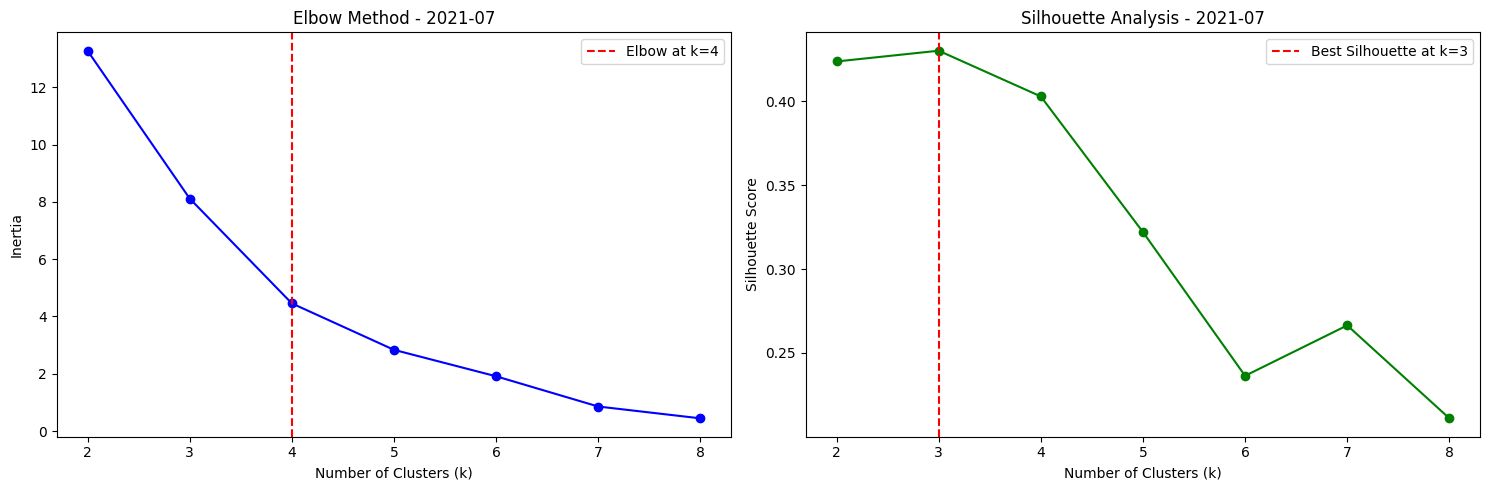

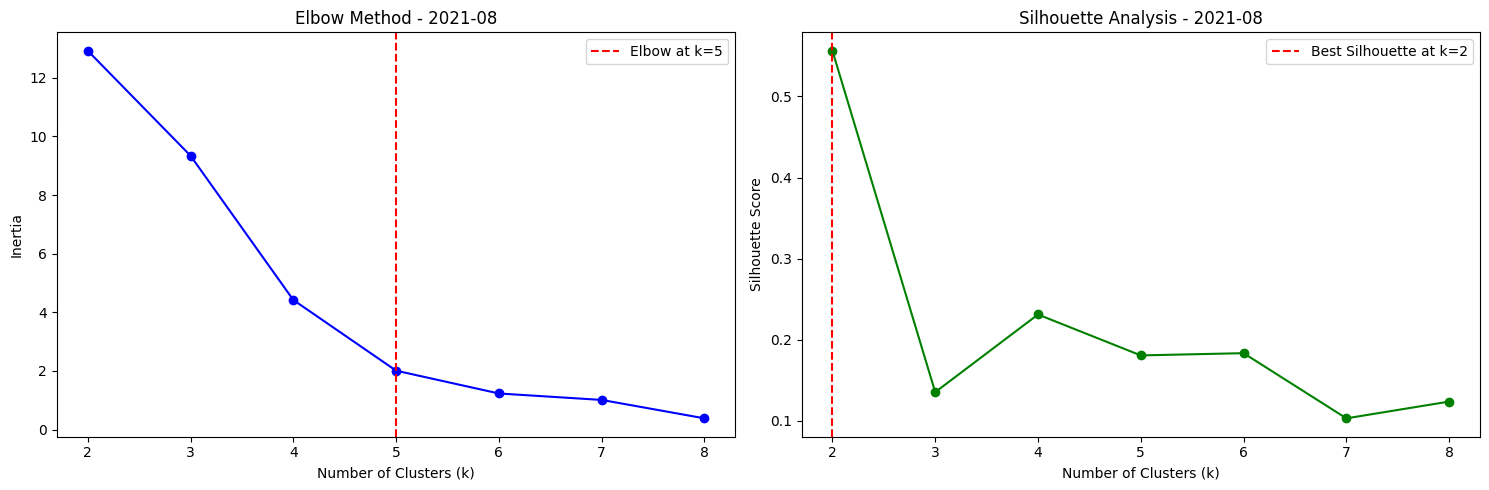

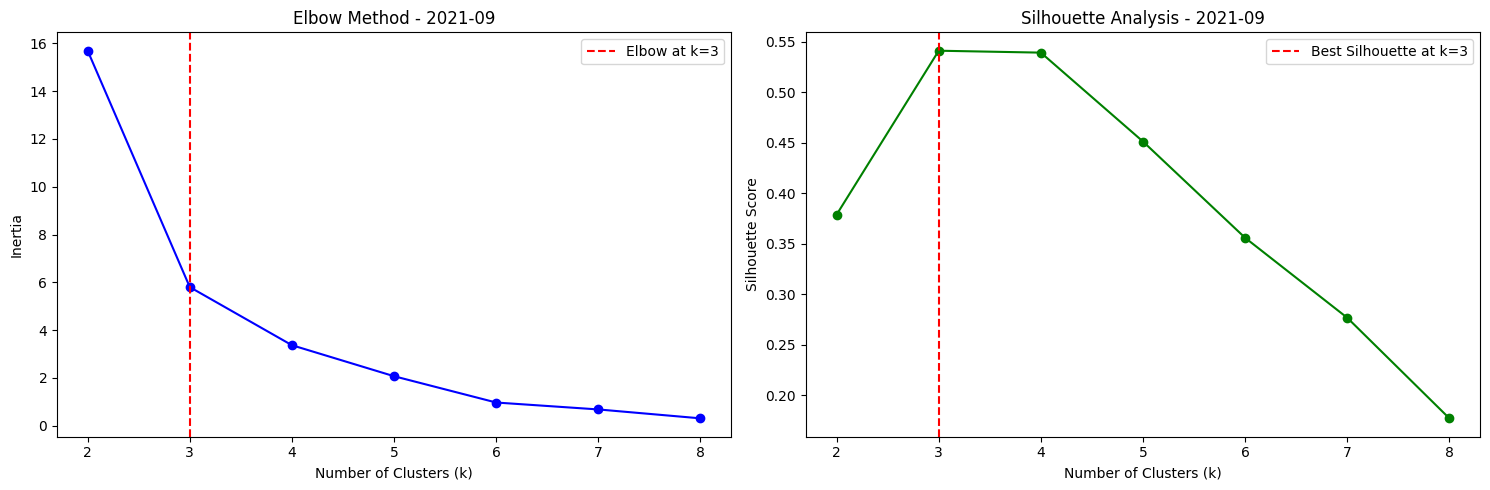

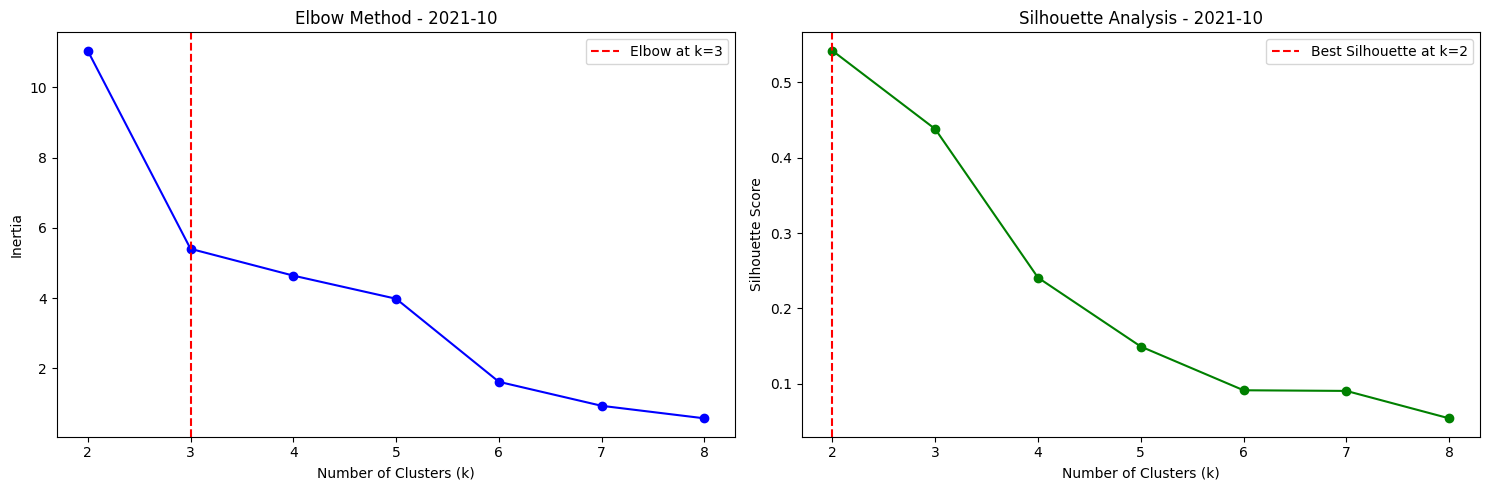

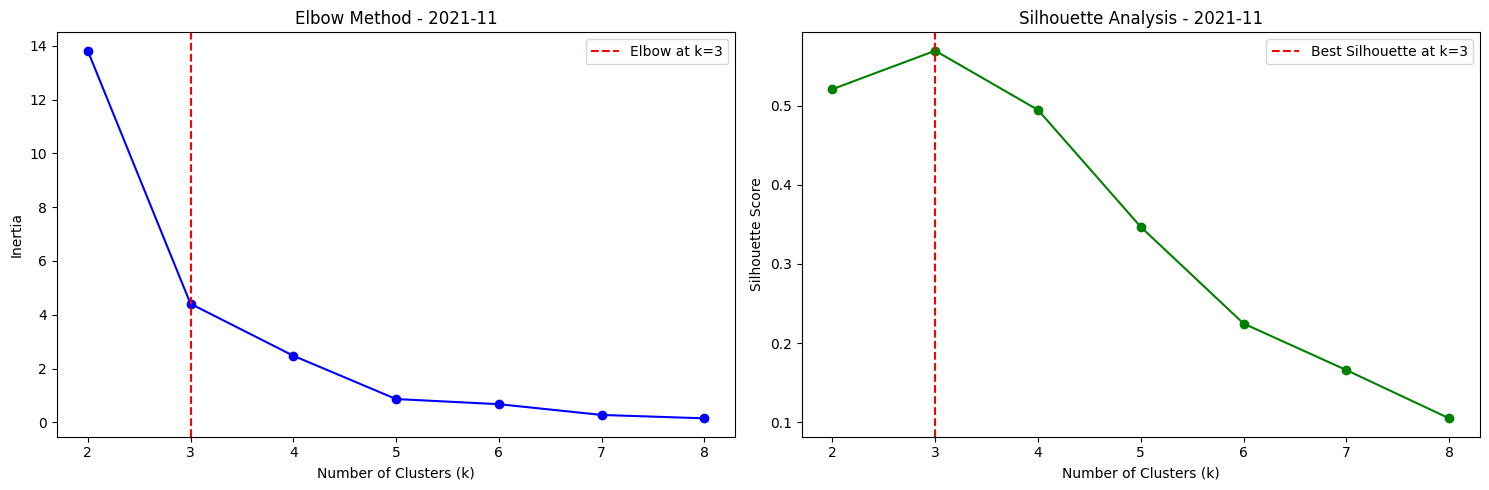

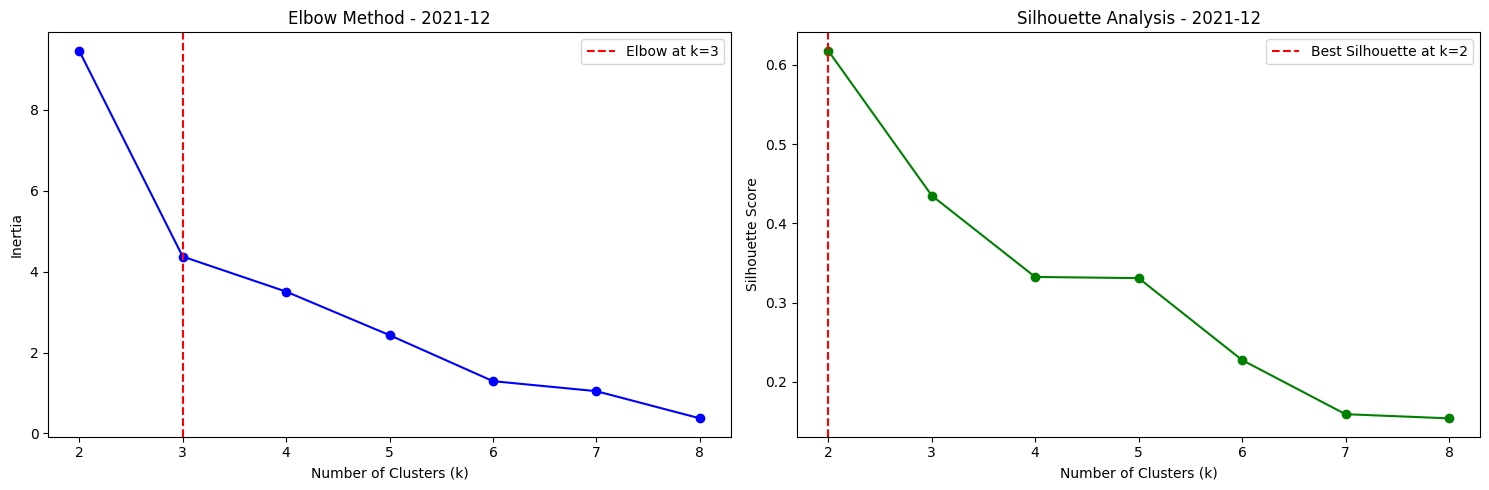


Cluster Number Recommendations:

Month		Elbow Method	Silhouette Method	Recommended
------------------------------------------------------------
2021-01		4		2			2
Justification for 2021-01:
- Elbow method suggests 4 clusters based on the point of diminishing returns
- Silhouette method suggests 2 clusters based on cluster cohesion
- Recommended 2 clusters as a compromise between methods

2021-02		3		2			3
Justification for 2021-02:
- Elbow method suggests 3 clusters based on the point of diminishing returns
- Silhouette method suggests 2 clusters based on cluster cohesion
- Recommended 3 clusters as a compromise between methods

2021-03		4		2			2
Justification for 2021-03:
- Elbow method suggests 4 clusters based on the point of diminishing returns
- Silhouette method suggests 2 clusters based on cluster cohesion
- Recommended 2 clusters as a compromise between methods

2021-04		4		3			4
Justification for 2021-04:
- Elbow method suggests 4 clusters based on the point of diminishing ret

In [ ]:
def evaluate_clusters(monthly_data, max_clusters=8):
    """Evaluate optimal number of clusters using multiple methods"""
    results = {}

    for month in monthly_data['Month'].unique():
        month_data = monthly_data[monthly_data['Month'] == month].copy()

        # Select features for clustering
        features = ['Std_Volatility', 'Monthly_Return', 'Price_Range']
        X = month_data[features]

        # Normalize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Initialize metrics
        inertias = []
        silhouette_scores = []

        # Calculate metrics for different numbers of clusters
        for k in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X_scaled)
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

        # Find elbow point using KneeLocator
        k_range = range(2, max_clusters + 1)
        kneedle = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')
        elbow_k = kneedle.elbow

        # Find optimal k based on silhouette score
        silhouette_k = k_range[np.argmax(silhouette_scores)]

        results[month] = {
            'elbow_k': elbow_k,
            'silhouette_k': silhouette_k,
            'inertias': inertias,
            'silhouette_scores': silhouette_scores
        }

        # Plot evaluation metrics
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Elbow curve
        ax1.plot(k_range, inertias, 'bo-')
        ax1.axvline(x=elbow_k, color='r', linestyle='--', label=f'Elbow at k={elbow_k}')
        ax1.set_xlabel('Number of Clusters (k)')
        ax1.set_ylabel('Inertia')
        ax1.set_title(f'Elbow Method - {month}')
        ax1.legend()

        # Silhouette score
        ax2.plot(k_range, silhouette_scores, 'go-')
        ax2.axvline(x=silhouette_k, color='r', linestyle='--',
                   label=f'Best Silhouette at k={silhouette_k}')
        ax2.set_xlabel('Number of Clusters (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title(f'Silhouette Analysis - {month}')
        ax2.legend()

        plt.tight_layout()
        plt.savefig(f'Cluster_Evaluation_{month}.png')
        plt.show()

    return results

def cluster_recommendations(results):
    """Get and print cluster number recommendations for each month"""
    print("\nCluster Number Recommendations:")
    print("\nMonth\t\tElbow Method\tSilhouette Method\tRecommended")
    print("-" * 60)

    list_of_recommended_k = []

    for month, metrics in results.items():
        elbow_k = metrics['elbow_k']
        silhouette_k = metrics['silhouette_k']

        # Make a recommendation based on both methods
        recommended_k = elbow_k if abs(elbow_k - silhouette_k) <= 1 else min(elbow_k, silhouette_k)
        list_of_recommended_k.append(recommended_k)

        print(f"{month}\t\t{elbow_k}\t\t{silhouette_k}\t\t\t{recommended_k}")

        # Print justification
        print(f"Justification for {month}:")
        print(f"- Elbow method suggests {elbow_k} clusters based on the point of diminishing returns")
        print(f"- Silhouette method suggests {silhouette_k} clusters based on cluster cohesion")
        if elbow_k != silhouette_k:
            print(f"- Recommended {recommended_k} clusters as a compromise between methods")
        print()

    return list_of_recommended_k

# Evaluate optimal number of clusters
cluster_results = evaluate_clusters(monthly_metrics)

# Get list of recommended number of clusters
list_of_recommended_k = cluster_recommendations(cluster_results)

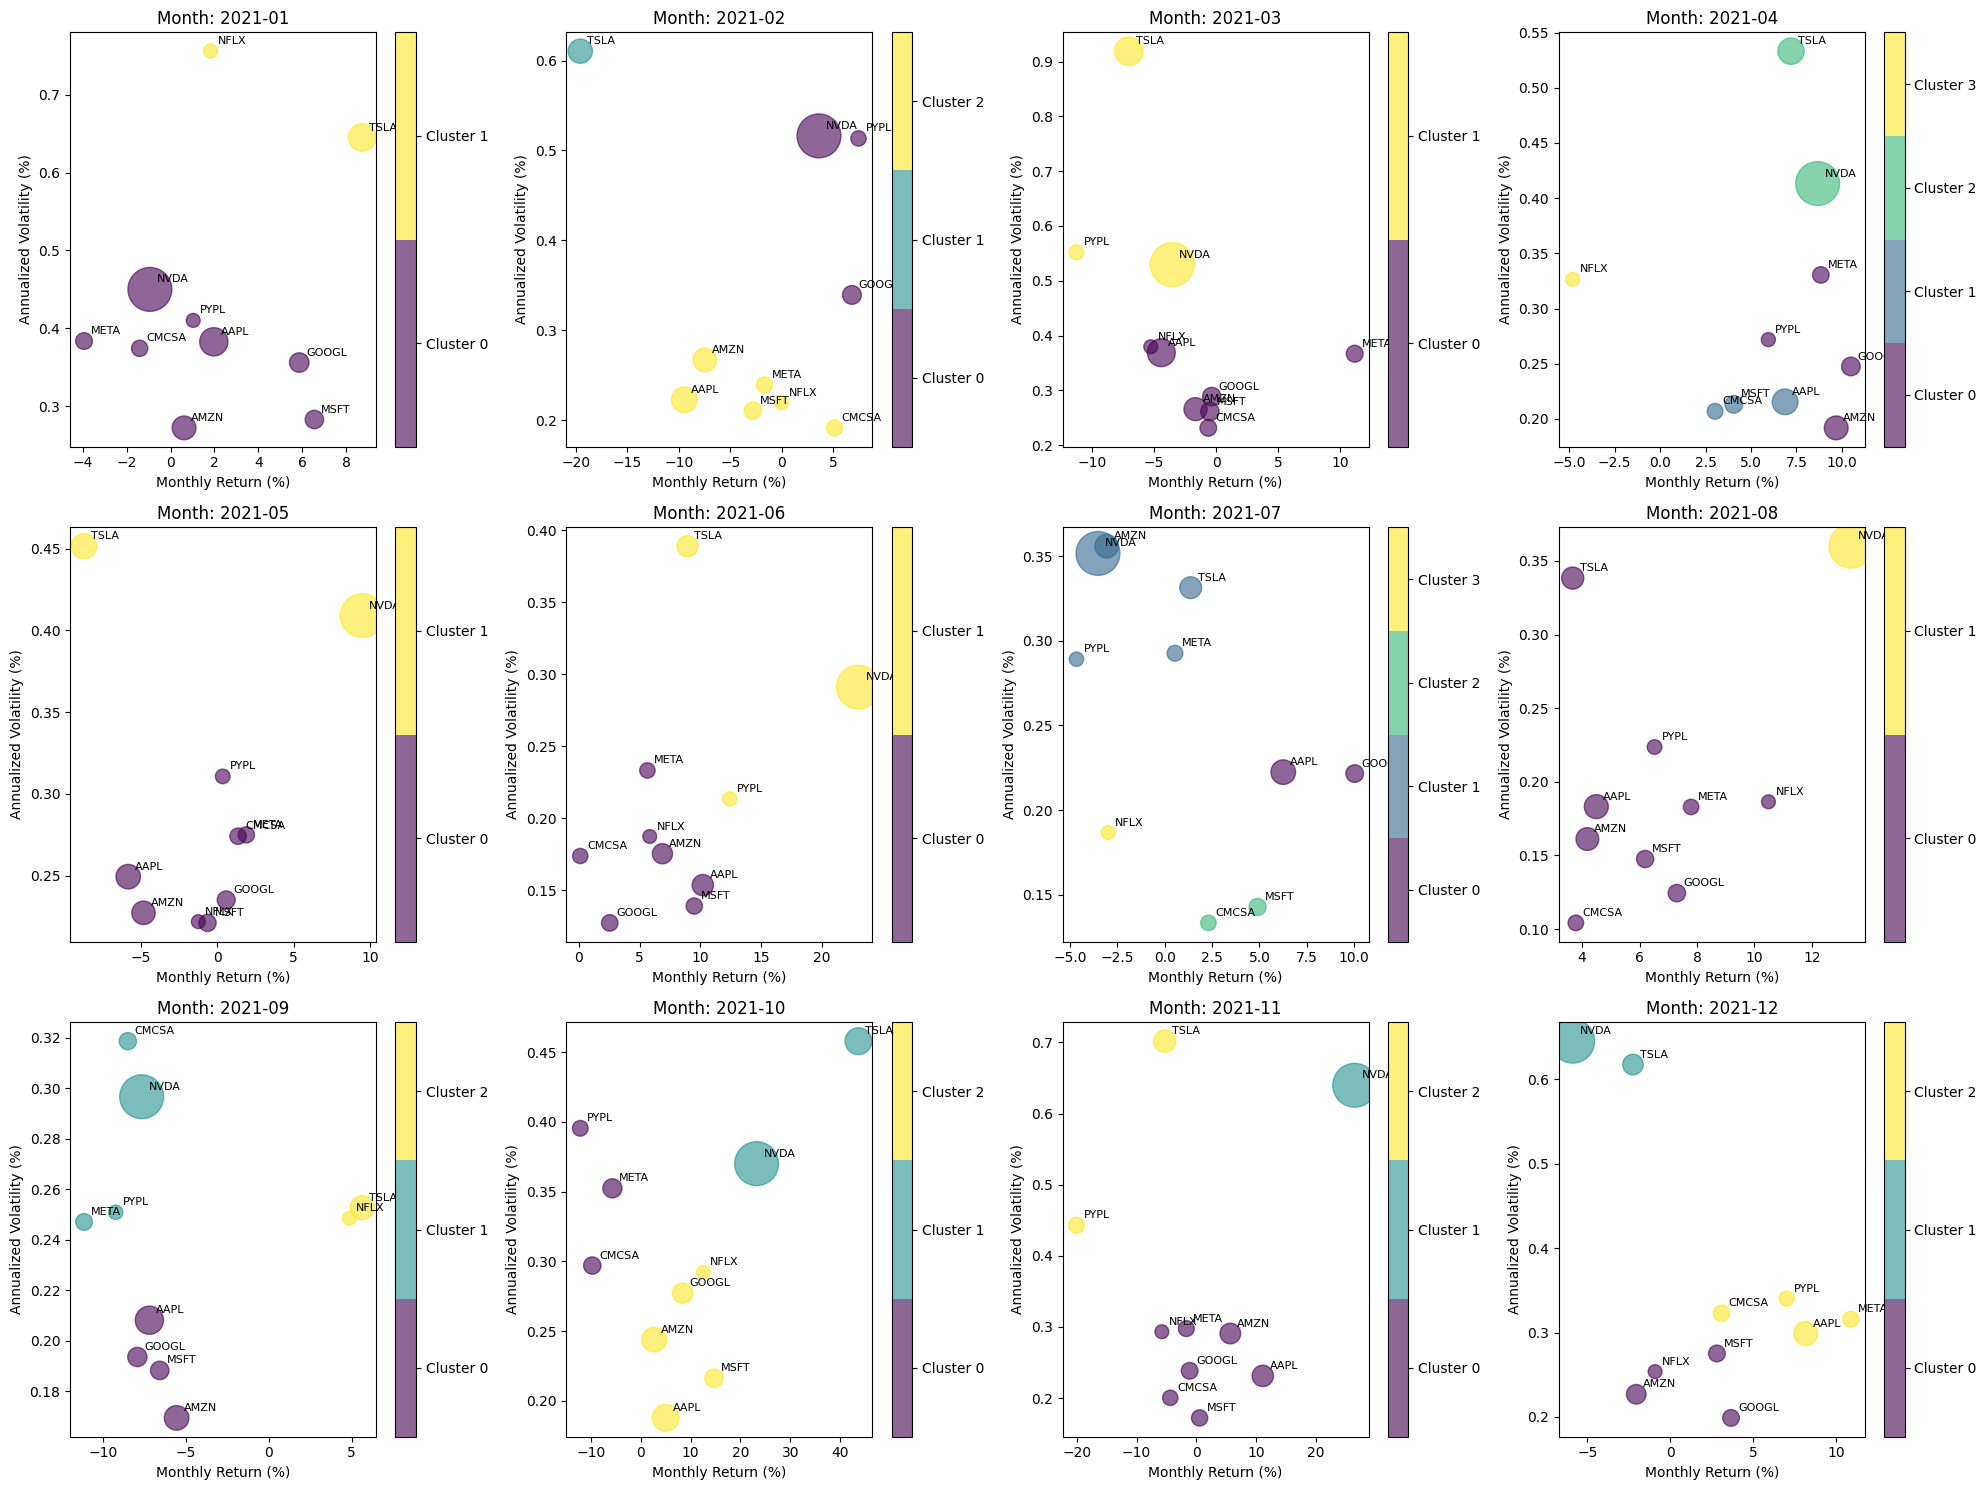


Analysis for 2021-01:

Cluster 0:
Stocks: AAPL, MSFT, AMZN, GOOGL, META, NVDA, PYPL, CMCSA
Average Monthly Return: 1.22%
Average Volatility: 0.36%
Average Price Range: 12.79%

Cluster 1:
Stocks: TSLA, NFLX
Average Monthly Return: 5.28%
Average Volatility: 0.70%
Average Price Range: 23.85%

Analysis for 2021-02:

Cluster 0:
Stocks: GOOGL, NVDA, PYPL
Average Monthly Return: 5.95%
Average Volatility: 0.46%
Average Price Range: 22.25%

Cluster 1:
Stocks: TSLA
Average Monthly Return: -19.57%
Average Volatility: 0.61%
Average Price Range: 42.25%

Cluster 2:
Stocks: AAPL, MSFT, AMZN, META, NFLX, CMCSA
Average Monthly Return: -2.72%
Average Volatility: 0.22%
Average Price Range: 10.78%

Analysis for 2021-03:

Cluster 0:
Stocks: AAPL, MSFT, AMZN, GOOGL, META, NFLX, CMCSA
Average Monthly Return: -0.23%
Average Volatility: 0.31%
Average Price Range: 10.96%

Cluster 1:
Stocks: TSLA, NVDA, PYPL
Average Monthly Return: -7.27%
Average Volatility: 0.67%
Average Price Range: 26.15%

Analysis for 2021-

In [ ]:
def cluster_monthly_data(monthly_data, list_of_recommended_k):
    """Perform clustering on monthly data"""
    # Create a list to store all clustered data
    all_clustered_data = []

    plt.figure(figsize=(20, 15))

    for i, month in enumerate(monthly_data['Month'].unique(), 1):
        # Create discrete colormap
        colors = plt.cm.viridis(np.linspace(0, 1, list_of_recommended_k[i-1]))
        discrete_cmap = plt.cm.colors.ListedColormap(colors)

        month_data = monthly_data[monthly_data['Month'] == month].copy()

        # Select features for clustering
        features = ['Std_Volatility', 'Monthly_Return', 'Price_Range']
        X = month_data[features]

        # Normalize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Perform clustering
        kmeans = KMeans(n_clusters=list_of_recommended_k[i-1], random_state=42)
        month_data['Cluster'] = kmeans.fit_predict(X_scaled)

        # Append this month's clustered data
        all_clustered_data.append(month_data)

        # Create subplot
        plt.subplot(3, 4, i)

        # Normalize bubble sizes based on volume
        size_scaler = MinMaxScaler(feature_range=(100, 1000))
        bubble_sizes = size_scaler.fit_transform(month_data[['Avg_Volume']].values)

        # Create bubble plot
        scatter = plt.scatter(
            month_data['Monthly_Return'],
            month_data['Std_Volatility'],
            c=month_data['Cluster'],
            s=bubble_sizes,
            alpha=0.6,
            cmap=discrete_cmap,
            vmin=-0.5,
            vmax=list_of_recommended_k[i-1]-0.5
        )

        # Annotate bubbles with ticker symbols
        for _, row in month_data.iterrows():
            plt.annotate(
                row['Ticker'],
                (row['Monthly_Return'], row['Std_Volatility']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8
            )

        plt.title(f'Month: {month}')
        plt.xlabel('Monthly Return (%)')
        plt.ylabel('Annualized Volatility (%)')

        # Add colorbar
        cbar = plt.colorbar(scatter, ticks=range(list_of_recommended_k[i-1]))
        cbar.set_ticklabels([f'Cluster {i}' for i in range(list_of_recommended_k[i-1])])

    plt.tight_layout()
    plt.savefig('Monthly_Volatility_Clusters.png')
    plt.show()

    # Concatenate all monthly data and return
    return pd.concat(all_clustered_data, ignore_index=True)

def print_cluster_analysis(monthly_data):
    """Print analysis of clusters"""
    for month in monthly_data['Month'].unique():
        month_data = monthly_data[monthly_data['Month'] == month]
        print(f"\nAnalysis for {month}:")

        for cluster in range(month_data['Cluster'].max() + 1):
            cluster_stocks = month_data[month_data['Cluster'] == cluster]
            print(f"\nCluster {cluster}:")
            print("Stocks:", ", ".join(cluster_stocks['Ticker']))
            print(f"Average Monthly Return: {cluster_stocks['Monthly_Return'].mean():.2f}%")
            print(f"Average Volatility: {cluster_stocks['Std_Volatility'].mean():.2f}%")
            print(f"Average Price Range: {cluster_stocks['Price_Range'].mean():.2f}%")

# Perform clustering and create visualizations
clustered_data = cluster_monthly_data(monthly_metrics, list_of_recommended_k)

# Print cluster analysis
print_cluster_analysis(clustered_data)